# CompGCN Graph Model Training - 800 - 200 - random valid

In [1]:
#!pip install pykeen
#!pip install seaborn

In [8]:
import numpy as np
import pandas as pd
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.predict import predict_target
import joblib
from sklearn.manifold import TSNE
from itertools import cycle
from sklearn.metrics import RocCurveDisplay, auc, roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.special import softmax
from tqdm.notebook import tqdm
from datetime import datetime

In [9]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
    # output expected:
    # tensor([1.], device='mps:0')


else:
    print ("MPS device not found.")

MPS device not found.


In [10]:
size_train = 800
y = joblib.load("../Data Generation/outcomes_800_200.joblib")
y_train = y[:size_train]
y_test = y[size_train:]
size_test = len(y_test)

In [11]:
pd.DataFrame(y).value_counts()

0
0    449
1    420
2    131
Name: count, dtype: int64

In [12]:
pd.DataFrame(y_train).value_counts()

0
0    362
1    337
2    101
Name: count, dtype: int64

In [13]:
pd.DataFrame(y_test).value_counts()

0
0    87
1    83
2    30
Name: count, dtype: int64

In [14]:
preproc_df = pd.read_csv("../Data Generation/sphn_transductive_800_200.nt", sep=" ")
preproc_df.drop(columns=preproc_df.columns[-1], axis=1, inplace=True)
preproc_df.to_csv("../Data Generation/sphn_transductive_800_200.tsv", sep="\t", index=False)
preproc_df

,<http://nvasc.org/9fb3e510-b2f7-45b8-948f-f348c3dd40d1>,<http://sphn.org/hasCode>,<http://nvasc.org/code_hct_0.0>
0,_:n1ecb46e8eba04039b40364b8a1bcec30b1,<http://sphn.org/hasUnit>,gcs
1,_:n91a6d6589e2546b7a0a07f0d87135c22b1,<http://sphn.org/hasValue>,19.7
2,<http://nvasc.org/3aca93ff-36cf-4fa1-97db-5e9e...,<http://www.w3.org/2000/01/rdf-schema#label>,tabagisme^^<http://www.w3.org/2001/XMLSchema#s...
3,<http://nvasc.org/f533b9e9-7c42-4330-8777-558b...,<http://sphn.org/hasSubjectPseudoIdentifier>,<http://nvasc.org/synth_patient_773>
4,<http://nvasc.org/5a17f78f-d2d5-496d-bd70-c71a...,<http://www.w3.org/2000/01/rdf-schema#label>,nb_acte
...,...,...,...
113224,<http://nvasc.org/4d495064-6a01-43c1-ac2c-d447...,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://sphn.org/Diagnosis>
113225,<http://nvasc.org/425eac2a-1dbd-4ef9-98c6-0763...,<http://sphn.org/hasCode>,<http://nvasc.org/code_hta_0.0>
113226,<http://nvasc.org/9d72e040-f384-4cde-b05e-449b...,<http://sphn.org/hasSubjectPseudoIdentifier>,<http://nvasc.org/synth_patient_517>
113227,_:nbbb52c21f60b49e2988d54fcaa5c315bb1,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://sphn.org/Quantity>


In [15]:
# tf = TriplesFactory.from_path("syn_data_graph.xml")
tf = TriplesFactory.from_path("../Data Generation/sphn_transductive_800_200.tsv")

In [41]:
n_runs = 1
epochs = 5

y_pred = np.zeros((n_runs, len(y_test)))
#y_pred = np.zeros((n_runs, len(y_train)))
y_probs = np.zeros((n_runs, len(y_test), 3))
#y_probs = np.zeros((n_runs, len(y_train), 3))
log_loss = np.zeros((n_runs, epochs))
hits = np.zeros((n_runs, 4))

In [18]:
print("start: " + str(datetime.now().isoformat()))
for run in range(n_runs):
    model_name = 'CompGCN'
    dataset = 'RIA'
    embedding_dim = 80

    tf.create_inverse_triples = True

    result = pipeline(
        model=model_name,       
        training=tf,
        testing=tf,
        model_kwargs=dict(
            embedding_dim=embedding_dim,      
            loss="softplus",
            random_seed=1234,
            #interaction="TransE",
            #interaction_kwargs=dict(
            #    p=2
            #)
        ),  
        optimizer_kwargs=dict(
            lr=0.001,
            weight_decay=1e-4,
        ),  
        training_kwargs=dict(
            num_epochs=epochs, 
            use_tqdm_batch=False,
        ),  
        training_loop='sLCWA',
        negative_sampler='basic',
        device='gpu',
        use_tqdm=False,
        
    )
print("end: " + str(datetime.now().isoformat()))

No random seed is specified. Setting to 1462678668.
SingleCompGCNRepresentation(
  (combined): CombinedCompGCNRepresentations(
    (entity_representations): Embedding(
      (_embeddings): Embedding(32758, 80)
    )
    (relation_representations): Embedding(
      (_embeddings): Embedding(18, 80)
    )
    (layers): ModuleList(
      (0): CompGCNLayer(
        (composition): MultiplicationCompositionModule()
        (edge_weighting): SymmetricEdgeWeighting()
        (w_rel): Linear(in_features=80, out_features=80, bias=False)
        (drop): Dropout(p=0.0, inplace=False)
        (bn): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bias): Bias()
        (activation): Identity()
      )
    )
  )
) provides 18 relation representations, although only 9 are needed.While this is not necessarily wrong, it can indicate an error where the number of relation representations was chosen wrong.
INFO:pykeen.triples.triples_factory:Creating inverse triples.


start: 2024-09-23T13:02:15.317468


INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/884 (0.11%) batches).
Evaluating on cuda:0: 100%|██████████| 113k/113k [00:15<00:00, 7.13ktriple/s] 
INFO:pykeen.evaluation.evaluator:Evaluation took 16.56s seconds


end: 2024-09-23T13:07:25.789929


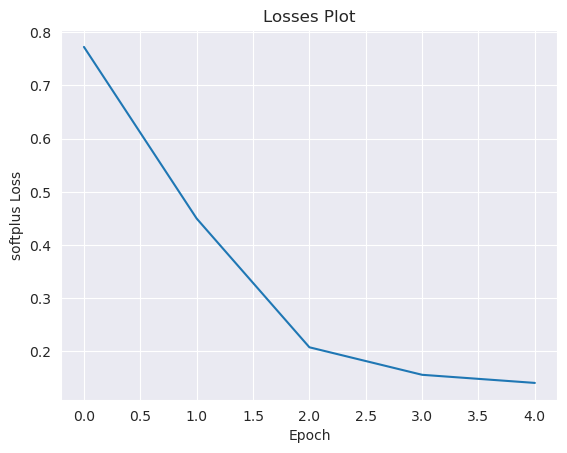

In [19]:
#plot loss
loss_plot = result.plot_losses()
#loss_plot.figure.savefig(f'loss_{model_name}_{embedding_dim}_{epochs}_{time.strftime("%Y%m%d-%H%M%S")}.png',dpi=600)

#log_loss[run] = result.losses

In [20]:
#print(len(y_train))
#print(list(range(len(y_train))))

In [21]:
preds = []
#for i in range(len(y_train)):
for i in range(len(y_test)):
    pred = predict_target(
            model=result.model,
            head=f"<http://nvasc.org/synth_patient_{size_train + i}>",
            #head=f"<http://nvasc.org/synth_patient_{i}>",
            relation="<http://nvasc.org/hasOutcome>",
            triples_factory=tf,
            targets=["<http://nvasc.org/outcome_0.0>", "<http://nvasc.org/outcome_1.0>", "<http://nvasc.org/outcome_2.0>"]
        )
    #print(pred)
    preds += [pred]
preds[0].df

,tail_id,score,tail_label
2,27723,-5.745574,<http://nvasc.org/outcome_2.0>
1,27722,-6.202007,<http://nvasc.org/outcome_1.0>
0,27721,-6.490653,<http://nvasc.org/outcome_0.0>


In [22]:
run = 0

y_pred[run] = np.array([
    np.argmin(
        [pred.df.reset_index(drop=True)['tail_label'][pred.df.reset_index(drop=True)['tail_label'] == output].index[0] for output in ["<http://nvasc.org/outcome_0.0>", "<http://nvasc.org/outcome_1.0>", "<http://nvasc.org/outcome_2.0>"]]
    )
    for pred in preds
    ])

y_probs[run] = np.array([
    softmax(
        [pred.df.reset_index(drop=True)['score'][pred.df.reset_index(drop=True)['tail_label'] == output].iloc[0] for output in ["<http://nvasc.org/outcome_0.0>", "<http://nvasc.org/outcome_1.0>", "<http://nvasc.org/outcome_2.0>"]]
    )
    for pred in preds
    ])

hits[run] = [
    round(result.get_metric('hits_at_1'), 2),
    round(result.get_metric('hits_at_3'), 2),
    round(result.get_metric('hits_at_5'), 2),
    round(result.get_metric('hits_at_10'), 2)
]

In [23]:
y_pred = mode(y_pred, axis=0).mode
y_score = np.mean(y_probs, axis=0)
hits = np.mean(hits, axis=0)

In [24]:
print("EVALUATION")
print("Hits@1", round(hits[0], 2))
print("Hits@3", round(hits[1], 2))
print("Hits@5", round(hits[2], 2))
print("Hits@10", round(hits[3], 2))

EVALUATION
Hits@1 0.42
Hits@3 0.58
Hits@5 0.63
Hits@10 0.7


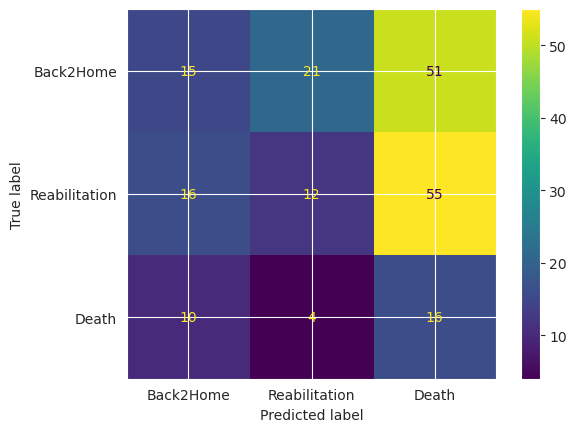

In [25]:
matrix = confusion_matrix(y_test, y_pred)
#matrix = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["Back2Home", "Reabilitation", "Death"])
disp.plot()
plt.show()

In [26]:
print(classification_report(y_test, y_pred, target_names=["Back2Home", "Reabilitation", "Death"]))
#print(classification_report(y_train, y_pred, target_names=["Back2Home", "Reabilitation", "Death"]))

               precision    recall  f1-score   support

    Back2Home       0.37      0.17      0.23        87
Reabilitation       0.32      0.14      0.20        83
        Death       0.13      0.53      0.21        30

     accuracy                           0.21       200
    macro avg       0.27      0.28      0.21       200
 weighted avg       0.31      0.21      0.22       200



In [27]:
print("AUC ROC:", round(roc_auc_score(y_test, y_score, multi_class='ovr'), 2))

AUC ROC: 0.43


In [28]:
model = result.model

entity_embedding_tensor = model.entity_representations[0](indices=None).cpu()
relation_embedding_tensor = model.relation_representations[0](indices=None).cpu()

In [29]:
colors = [['g', 'r', 'b'][i] for i in y_train]
labels = [i for i in y_train]
#patients_names = [f"P{i}" for i in range(size_train)]
patients_names = [f"<http://nvasc.org/synth_patient_{i}>" for i in range(size_train)]
train_pos = entity_embedding_tensor[tf.entities_to_ids(patients_names)]
train_pos = train_pos.detach().numpy()

In [30]:
out_colors = ['g', 'r', 'b']
#outcomes_names = ["Back2Home", "Reabilitation", "Death"]
outcomes_names = ["<http://nvasc.org/outcome_0.0>", "<http://nvasc.org/outcome_1.0>", "<http://nvasc.org/outcome_2.0>"]
out_pos = entity_embedding_tensor[tf.entities_to_ids(outcomes_names)]
out_pos = out_pos.detach().numpy()

In [31]:
pca = PCA(n_components=2)
train_pos = pca.fit_transform(train_pos)
out_pos = pca.transform(out_pos)

In [32]:
print(f"{round(sum(pca.explained_variance_), 2)}% variance explained")

12.25% variance explained


In [33]:
#relation_names = ["hasOutput", "output"]
relation_names = ["<http://nvasc.org/hasOutcome>"]
rel_pos = relation_embedding_tensor[tf.relations_to_ids(relation_names)]
rel_pos = rel_pos.detach().numpy()
origin = np.array([[0] * 2, [0] * 2])

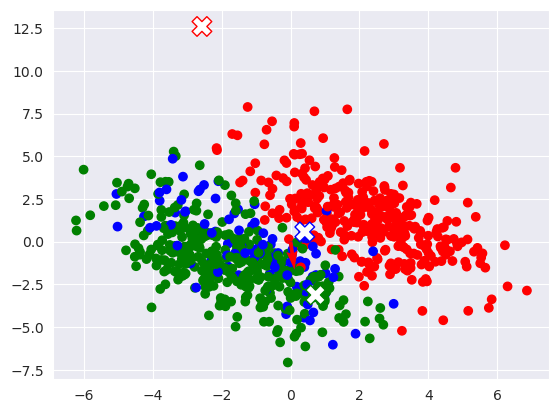

In [34]:
plt.scatter(train_pos[:,0], train_pos[:,1], c=colors)
plt.scatter(out_pos[:,0], out_pos[:,1], s=200, marker='X', edgecolors=out_colors, facecolors=['w'] * len(out_colors))
plt.quiver(*origin, rel_pos[:,0], rel_pos[:,1], scale=8, color=['b', 'r'])
plt.show()

In [35]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape

(200, 3)

In [36]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.37


In [37]:
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.43


In [38]:
class_weights = [0.443396, 0.432075, 0.124529]

# Compute ROC curve and ROC area for each class with sample weights
for i in range(n_classes):
    sample_weight = np.ones(y_onehot_test.shape[0]) * class_weights[i]
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i], sample_weight=sample_weight)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Interpolation grid
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
weighted_mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    interp_tpr = np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
    weighted_mean_tpr += class_weights[i] * interp_tpr

# Compute AUC for the weighted macro-average
fpr["weighted_macro"] = fpr_grid
tpr["weighted_macro"] = weighted_mean_tpr
roc_auc["weighted_macro"] = auc(fpr["weighted_macro"], tpr["weighted_macro"])

print(f"Weighted Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['weighted_macro']:.2f}")


Weighted Macro-averaged One-vs-Rest ROC AUC score:
0.44


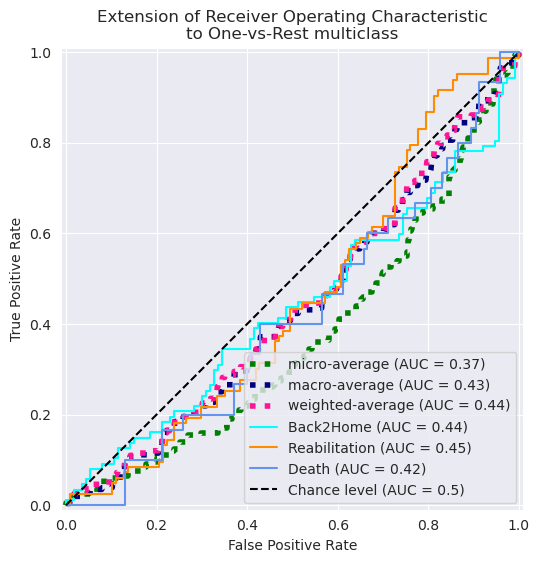

In [39]:
fig, ax = plt.subplots(figsize=(6, 6))

target_names = ["Back2Home", "Reabilitation", "Death"]

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average (AUC = {roc_auc['micro']:.2f})",
    color="green",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["weighted_macro"],
    tpr["weighted_macro"],
    label=f"weighted-average (AUC = {roc_auc['weighted_macro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

#ax.grid(False)
#ax.set_facecolor('white')

plt.savefig("test.png")

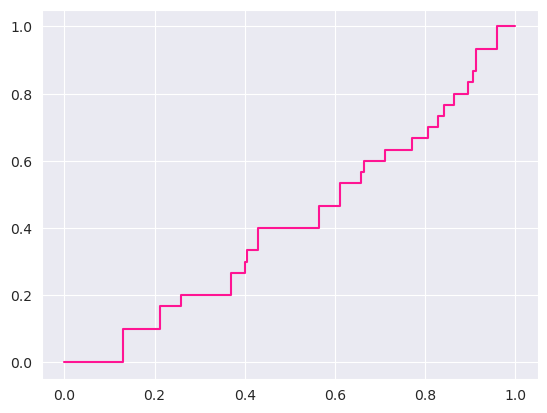

In [40]:
plt.plot(
    fpr[2],
    tpr[2],
    label=f"weighted-average (AUC = {roc_auc['weighted_macro']:.2f})",
    color="deeppink",
)